In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import plotly.express as px

# Set a style for our plots
sns.set_style("darkgrid")

# Load the dataset
df_togo = pd.read_csv('../data/togo-dapaong_qc.csv')

# --- Chunk 1: Load Data ---
print("--- First 5 Rows ---")
print(df_togo.head())

# --- Chunk 2: Summary Statistics & Missing-Value Report ---

# 1. Summary Statistics
print("\n--- Summary Statistics (df.describe) ---")
print(df_togo.describe())

# 2. Missing-Value Report
print("\n--- Missing Value Report (df.isna().sum()) ---")
missing_values = df_togo.isna().sum()
print(missing_values)

# 3. List columns with >5% nulls
print("\n--- Columns with >5% Missing Values ---")
total_rows = len(df_togo)
missing_percentage = (missing_values / total_rows) * 100
print(missing_percentage[missing_percentage > 5])

--- First 5 Rows ---
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

In [2]:
# --- Chunk 3: Basic Cleaning ---

# Create a copy
df_togo_clean = df_togo.copy()

# 1. Drop the 100% missing columns
cols_to_drop = ['WSgust', 'WSstdev', 'WDstdev', 'Comments']
df_togo_clean = df_togo_clean.drop(cols_to_drop, axis=1)
print(f"Dropped columns: {cols_to_drop}")

# 2. Clean negative irradiance values (clip them at 0)
irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in irradiance_cols:
    df_togo_clean[col] = df_togo_clean[col].clip(lower=0)
print("Clipped negative irradiance values to 0.")

# 3. Convert 'Timestamp' to datetime object and set as index
df_togo_clean['Timestamp'] = pd.to_datetime(df_togo_clean['Timestamp'])
df_togo_clean = df_togo_clean.set_index('Timestamp')
print("Converted 'Timestamp' to datetime index.")

# 4. Check the 'min' values to confirm fix
print("\n--- New Summary Statistics (min values only) ---")
print(df_togo_clean[irradiance_cols].min())


# --- Chunk 4: Z-Score Outlier Detection ---

# Columns to check for outliers (excluding dropped cols)
zscore_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS']
for col in zscore_cols:
    df_togo_clean[f'{col}_zscore'] = np.abs(zscore(df_togo_clean[col]))

# Flag rows with Z > 3
z_cols_to_check = [f'{col}_zscore' for col in zscore_cols]
df_togo_clean['is_outlier'] = df_togo_clean[z_cols_to_check].gt(3).any(axis=1)

# Report on our findings
outlier_count = df_togo_clean['is_outlier'].sum()
total_rows = len(df_togo_clean)
print(f"\nTotal rows flagged as outliers (Z-score > 3): {outlier_count}")
print(f"Percentage of data flagged: {(outlier_count / total_rows) * 100:.2f}%")

Dropped columns: ['WSgust', 'WSstdev', 'WDstdev', 'Comments']
Clipped negative irradiance values to 0.
Converted 'Timestamp' to datetime index.

--- New Summary Statistics (min values only) ---
GHI     0.0
DNI     0.0
DHI     0.0
ModA    0.0
ModB    0.0
dtype: float64

Total rows flagged as outliers (Z-score > 3): 8224
Percentage of data flagged: 1.56%


Successfully saved cleaned data to: ../data/togo_clean.csv


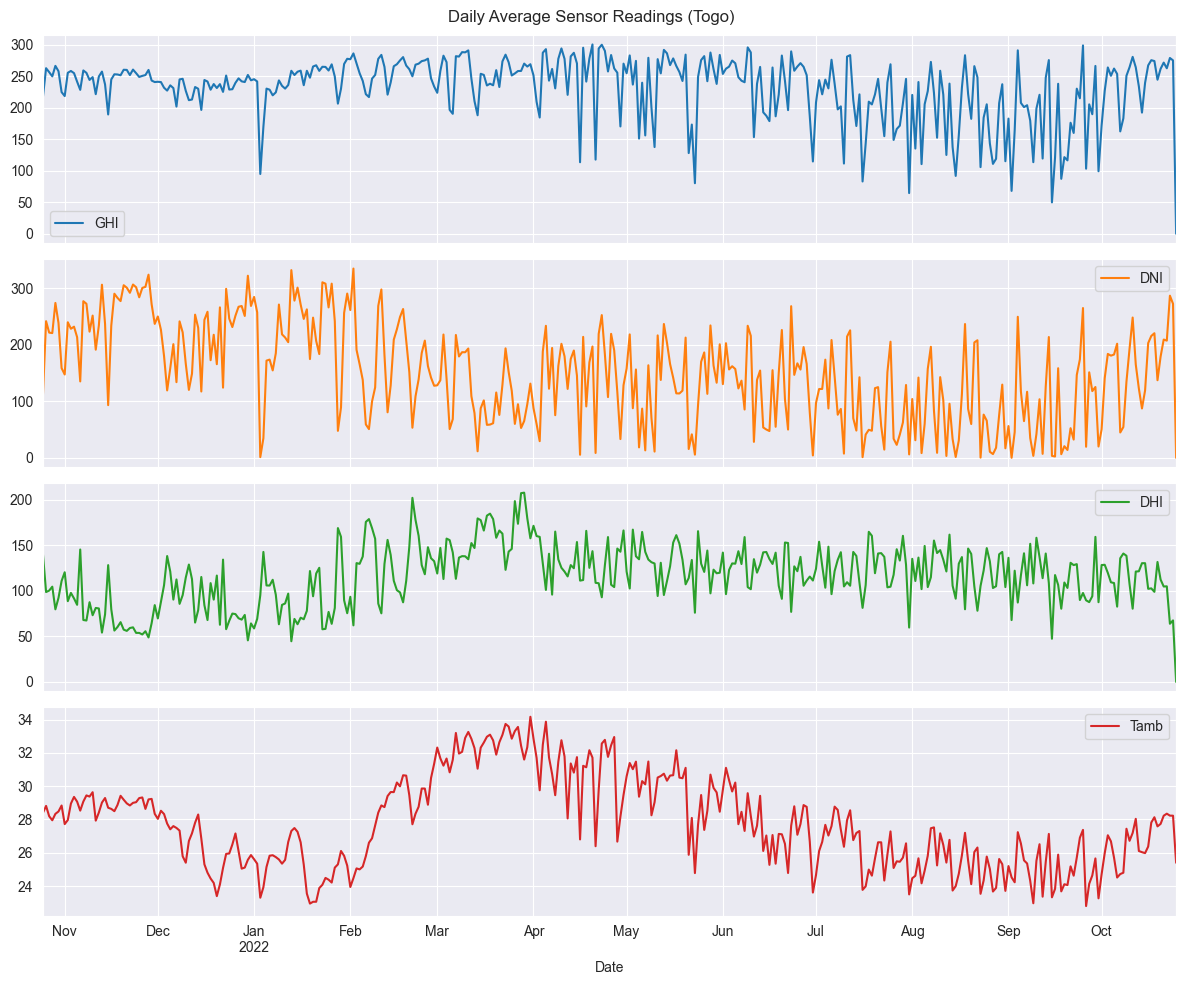


--- Average Sensor Reading by Cleaning Status (Togo) ---
                ModA        ModB
Cleaning                        
0         225.979064  219.401351
1         535.186477  532.211744


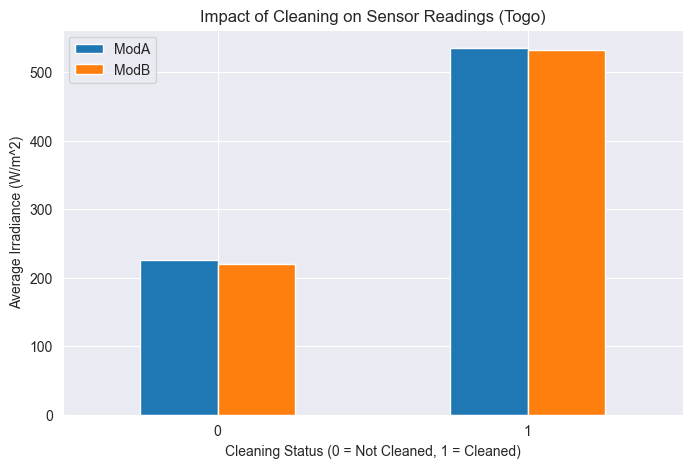

In [3]:
# --- Chunk 5: Export Cleaned Data ---

# Select the original columns to save
columns_to_save = df_togo.columns.drop(['WSgust', 'WSstdev', 'WDstdev', 'Comments', 'Timestamp'])
df_to_save = df_togo_clean[columns_to_save]

# Save the cleaned DataFrame
output_path = '../data/togo_clean.csv'
df_to_save.to_csv(output_path)
print(f"Successfully saved cleaned data to: {output_path}")


# --- Chunk 6: Time Series Analysis ---

# Resample by Day
df_daily_mean = df_togo_clean.resample('D').mean()
plot_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# Plot
df_daily_mean[plot_cols].plot(
    subplots=True,
    figsize=(12, 10),
    title='Daily Average Sensor Readings (Togo)',
    legend=True
)
plt.xlabel('Date')
plt.tight_layout()
plt.show()


# --- Chunk 7: Cleaning Impact Analysis ---

# Group by 'Cleaning' and get mean
cleaning_impact = df_togo_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
print("\n--- Average Sensor Reading by Cleaning Status (Togo) ---")
print(cleaning_impact)

# Plot
cleaning_impact.plot(
    kind='bar',
    title='Impact of Cleaning on Sensor Readings (Togo)',
    figsize=(8, 5)
)
plt.ylabel('Average Irradiance (W/m^2)')
plt.xlabel('Cleaning Status (0 = Not Cleaned, 1 = Cleaned)')
plt.xticks(rotation=0)
plt.show()

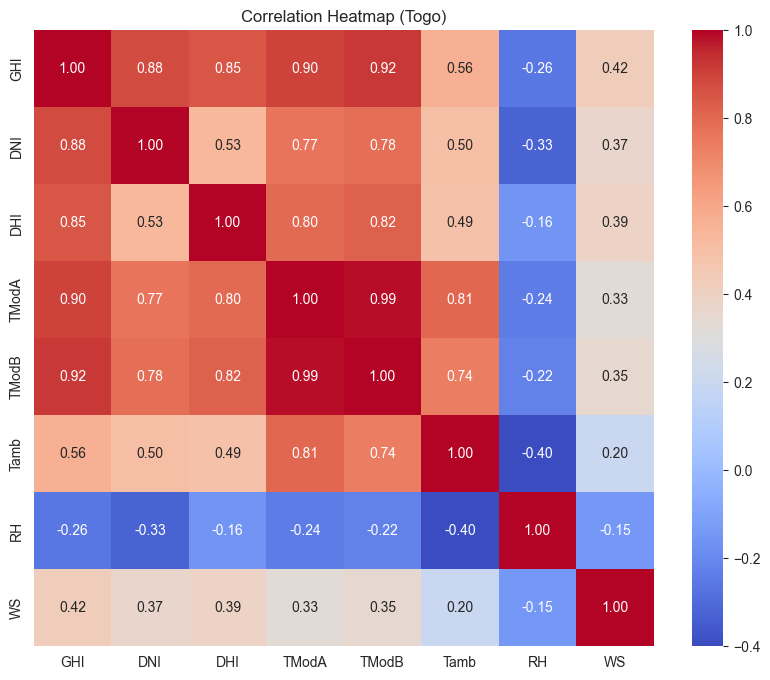

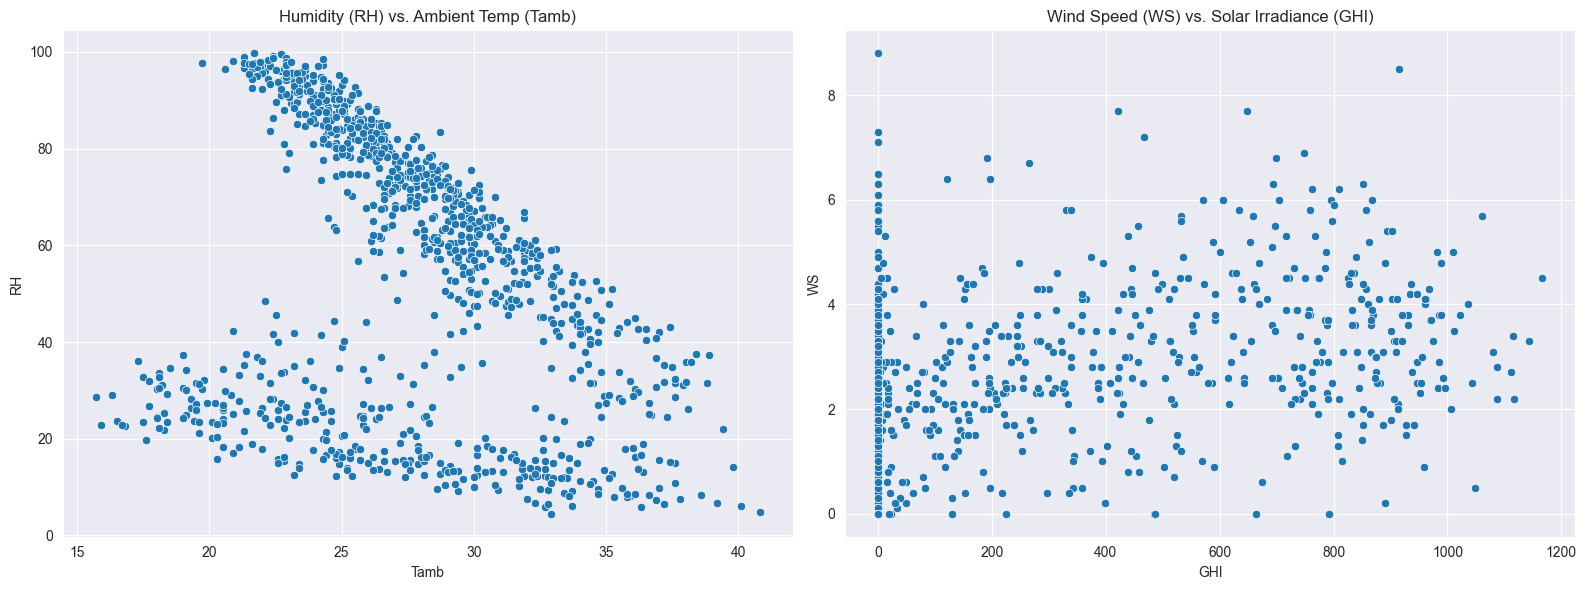

In [4]:
# --- Chunk 8: Correlation Heatmap ---

corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS']
corr_matrix = df_togo_clean[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Togo)')
plt.show()


# --- Chunk 9: Relationship Scatter Plots ---

# Create a sample
df_sample = df_togo_clean.sample(n=1000, random_state=42)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RH vs. Tamb
sns.scatterplot(data=df_sample, x='Tamb', y='RH', ax=ax1)
ax1.set_title('Humidity (RH) vs. Ambient Temp (Tamb)')

# Plot 2: WS vs. GHI
sns.scatterplot(data=df_sample, x='GHI', y='WS', ax=ax2)
ax2.set_title('Wind Speed (WS) vs. Solar Irradiance (GHI)')

plt.tight_layout()
plt.show()

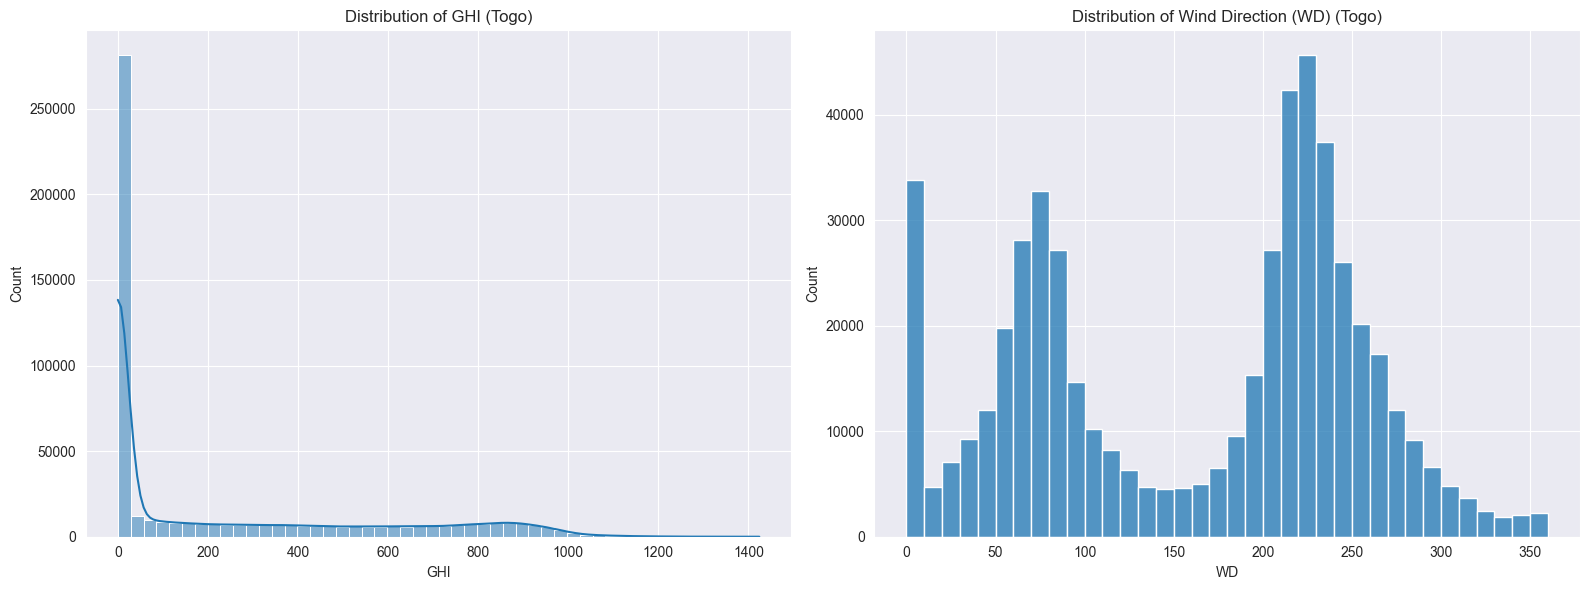

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_24648/3267217731.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose_data = df_togo_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')


In [5]:
# --- Chunk 10: Distribution Histograms ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=df_togo_clean, x='GHI', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of GHI (Togo)')

sns.histplot(data=df_togo_clean, x='WD', bins=36, kde=False, ax=ax2)
ax2.set_title('Distribution of Wind Direction (WD) (Togo)')

plt.tight_layout()
plt.show()


# --- Chunk 11: Wind Rose ---

df_togo_clean['WD_binned'] = pd.cut(
    df_togo_clean['WD'], bins=16,
    labels=['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
)
df_togo_clean['WS_binned'] = pd.cut(
    df_togo_clean['WS'], bins=[0, 2, 4, 6, 8, 10, 100],
    labels=['0-2', '2-4', '4-6', '6-8', '8-10', '>10']
)

wind_rose_data = df_togo_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')

fig_rose = px.bar_polar(
    wind_rose_data, r="count", theta="WD_binned", color="WS_binned",
    title="Wind Rose for Togo", template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma_r
)
fig_rose.show()


# --- Chunk 12: Bubble Chart ---

fig_bubble = px.scatter(
    df_sample, x="GHI", y="Tamb", size="RH", color="RH",
    title="GHI vs. Ambient Temp (Bubble size = RH) (Togo)",
    template="plotly_dark", size_max=15
)
fig_bubble.update_layout(xaxis_title="GHI (W/m^2)", yaxis_title="Ambient Temp (°C)")
fig_bubble.show()